<a href="https://colab.research.google.com/github/CarlosModinez/brazilian_weeds/blob/main/weed_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Utils**
Don't run it if your dataset is structured

In [ ]:
import shutil

DATASET_PATH = "drive/My Drive/TCC/brazilian_weeds_2020"
classes = os.listdir(DATASET_PATH)

def search_images(path, image_paths=[]):
    image_extensions = ['jpg', 'jpeg']

    if os.path.exists(path) and os.path.isdir(path):
        for file in os.listdir(path):
            file_extension = file.split(".")[-1].lower()
            if file_extension in image_extensions:
                  image_paths.append(os.path.join(path, file))
            elif os.path.isdir(os.path.join(path, file)):
                search_images(os.path.join(path, file), image_paths)
    return image_paths

def get_class(image_path, classes):
  for plant_class in classes:
    if plant_class.lower() in image_path.lower():
      return plant_class
  return None

def build_dataset(dataset_path, classes):
  image_paths = search_images(dataset_path)

  for image_path in image_paths:
    label = get_class(image_path, classes)
    destination_path = "drive/My Drive/TCC/brazilian_weeds_2020_classification/" + label + "/"

    if not os.path.exists(destination_path):
      os.makedirs(destination_path)

    shutil.copy(image_path, destination_path)

build_dataset(DATASET_PATH, classes)

## Classifier

In [ ]:
DATASET_PATH = "drive/My Drive/TCC/brazilian_weeds_2020_classification"
os.listdir(DATASET_PATH)

['Amaranthaceae',
 'Asteraceae',
 'Lamiaceae',
 'Convolvulaceae',
 'Solanaceae',
 'Poaceae',
 'Apiaceae',
 'Brassicaceae']

In [ ]:
img_height = 1024
img_width = 1024
batch_size = 32

full_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  image_size=(img_width, img_height),
  batch_size=batch_size,
  shuffle=True,
  seed=123  # Set seed for reproducibility
)

total_samples = len(full_ds)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_ds = full_ds.take(train_size)
remaining_ds = full_ds.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

Found 752 files belonging to 8 classes.


In [ ]:
class_names = full_ds.class_names
class_names

['Amaranthaceae',
 'Apiaceae',
 'Asteraceae',
 'Brassicaceae',
 'Convolvulaceae',
 'Lamiaceae',
 'Poaceae',
 'Solanaceae']

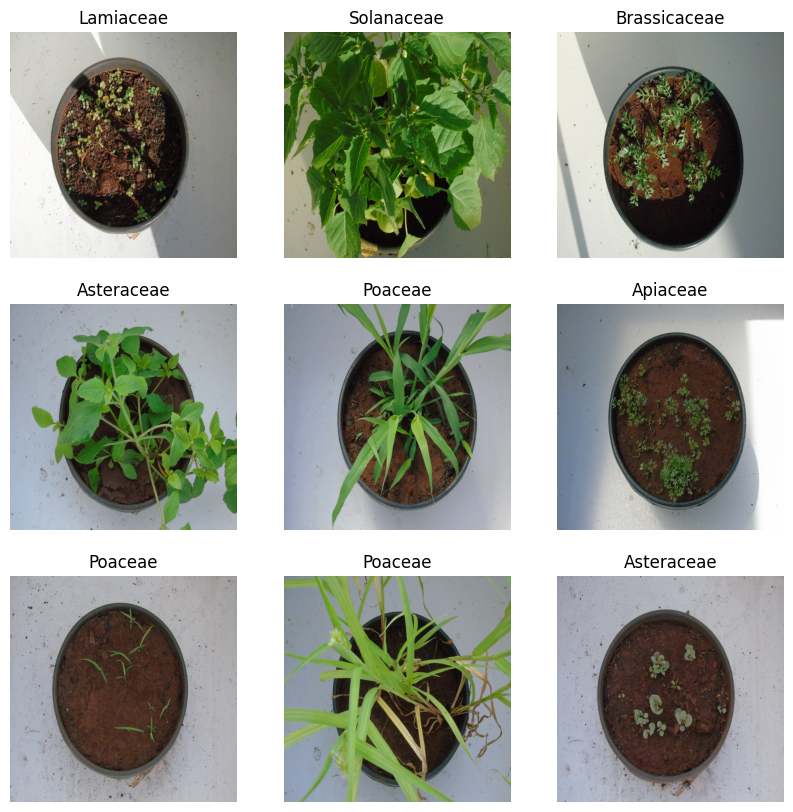

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal", input_shape=(img_width,img_height,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

### Custom model

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_width, img_height, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
METRICS = [
  keras.metrics.BinaryCrossentropy(name='cross entropy'),
  keras.metrics.MeanSquaredError(name='Brier score'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'),
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR')
]

#### Loss: SparseCategoricalCrossentropy
It's not property for imbalanced data

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 44s 2s/step - loss: 5.1599 - accuracy: 0.2578 - val_loss: 1.7638 - val_accuracy: 0.4271
Epoch 2/15
16/16 [==============================] - 6s 368ms/step - loss: 1.8761 - accuracy: 0.3477 - val_loss: 1.8235 - val_accuracy: 0.4271
Epoch 3/15
16/16 [==============================] - 6s 363ms/step - loss: 1.8785 - accuracy: 0.3477 - val_loss: 1.7806 - val_accuracy: 0.4271
Epoch 4/15
16/16 [==============================] - 6s 363ms/step - loss: 1.8636 - accuracy: 0.3477 - val_loss: 1.7717 - val_accuracy: 0.4271
Epoch 5/15
16/16 [==============================] - 6s 364ms/step - loss: 1.8566 - accuracy: 0.3477 - val_loss: 1.8147 - val_accuracy: 0.4271
Epoch 6/15
16/16 [==============================] - 6s 364ms/step - loss: 1.8495 - accuracy: 0.3477 - val_loss: 1.7549 - val_accuracy: 0.4271
Epoch 7/15
16/16 [==============================] - 6s 365ms/step - loss: 1.8471 - accuracy: 0.3477 - val_loss: 1.7388 - val_accuracy: 0.4271
Epoch 8/

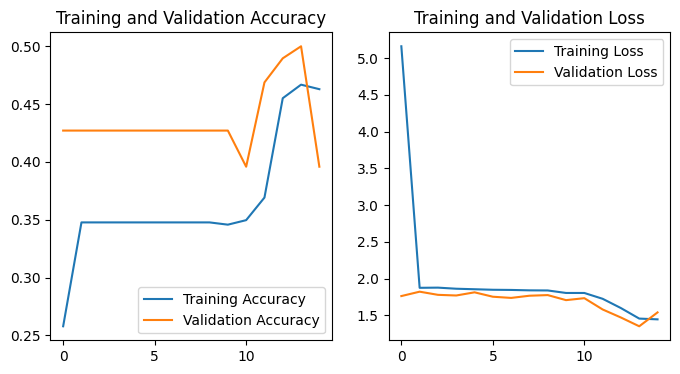

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Assuming you have loaded your test dataset into the variable test_ds

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 29s 277ms/step


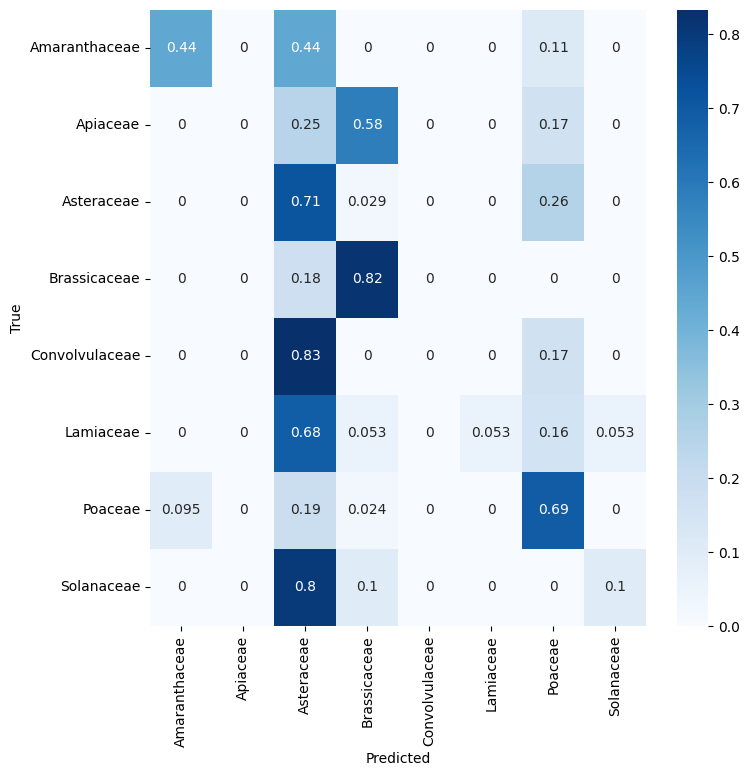

                precision    recall  f1-score   support

 Amaranthaceae       0.50      0.44      0.47         9
      Apiaceae       0.00      0.00      0.00        12
    Asteraceae       0.37      0.71      0.49        35
  Brassicaceae       0.45      0.82      0.58        11
Convolvulaceae       0.00      0.00      0.00         6
     Lamiaceae       1.00      0.05      0.10        19
       Poaceae       0.64      0.69      0.67        42
    Solanaceae       0.50      0.10      0.17        10

      accuracy                           0.48       144
     macro avg       0.43      0.35      0.31       144
  weighted avg       0.51      0.48      0.41       144



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


#### Focal loss
It's supposed to be better for imbalanced data

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, **kwargs):
        self.alpha = alpha
        self.gamma = gamma
        super(FocalLoss, self).__init__(**kwargs)

    def call(self, y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.math.exp(-ce_loss)
        focal_loss = self.alpha * tf.math.pow(1.0 - pt, self.gamma) * ce_loss
        return focal_loss

model.compile(
    optimizer='adam',
    loss=FocalLoss(),
    metrics=['accuracy']
)

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
16/16 [==============================] - 9s 401ms/step - loss: 0.2485 - accuracy: 0.4609 - val_loss: 0.2342 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 6s 365ms/step - loss: 0.2082 - accuracy: 0.5273 - val_loss: 0.2064 - val_accuracy: 0.5208
Epoch 3/30
16/16 [==============================] - 6s 363ms/step - loss: 0.1897 - accuracy: 0.5664 - val_loss: 0.2018 - val_accuracy: 0.4896
Epoch 4/30
16/16 [==============================] - 6s 364ms/step - loss: 0.1819 - accuracy: 0.5684 - val_loss: 0.2249 - val_accuracy: 0.4896
Epoch 5/30
16/16 [==============================] - 6s 365ms/step - loss: 0.1822 - accuracy: 0.5781 - val_loss: 0.1692 - val_accuracy: 0.5833
Epoch 6/30
16/16 [==============================] - 6s 364ms/step - loss: 0.1623 - accuracy: 0.6055 - val_loss: 0.1847 - val_accuracy: 0.5833
Epoch 7/30
16/16 [==============================] - 6s 363ms/step - loss: 0.1468 - accuracy: 0.6484 - val_loss: 0.1931 - val_accuracy: 0.5417
Epoch 

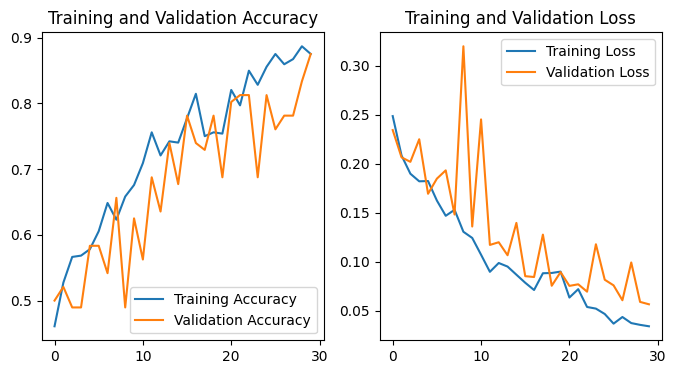

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 1s 165ms/step


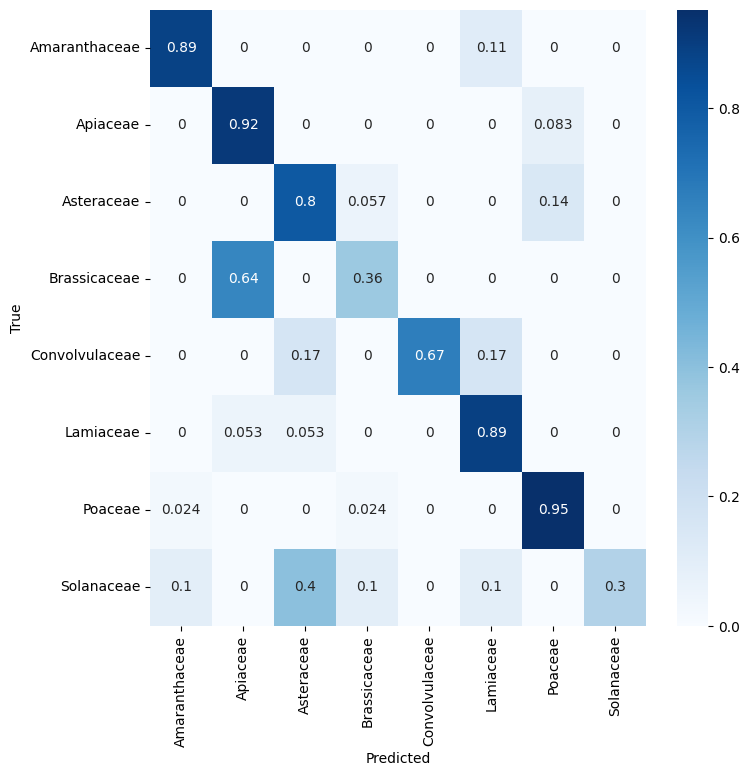

                precision    recall  f1-score   support

 Amaranthaceae       0.80      0.89      0.84         9
      Apiaceae       0.58      0.92      0.71        12
    Asteraceae       0.82      0.80      0.81        35
  Brassicaceae       0.50      0.36      0.42        11
Convolvulaceae       1.00      0.67      0.80         6
     Lamiaceae       0.85      0.89      0.87        19
       Poaceae       0.87      0.95      0.91        42
    Solanaceae       1.00      0.30      0.46        10

      accuracy                           0.80       144
     macro avg       0.80      0.72      0.73       144
  weighted avg       0.81      0.80      0.79       144



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


#### Weighted Cross-Entropy

In [ ]:
train_labels = np.array([])
for images, labels in train_ds.take(len(train_ds)):
  train_labels = np.concatenate((train_labels, labels.numpy()), axis=0)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    loss_weights=class_weights
)

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
16/16 [==============================] - 8s 375ms/step - loss: 0.8862 - accuracy: 0.7891 - val_loss: 1.0847 - val_accuracy: 0.7500
Epoch 2/30
16/16 [==============================] - 6s 363ms/step - loss: 0.5105 - accuracy: 0.8633 - val_loss: 0.8499 - val_accuracy: 0.8021
Epoch 3/30
16/16 [==============================] - 6s 365ms/step - loss: 0.4591 - accuracy: 0.8906 - val_loss: 0.7100 - val_accuracy: 0.8333
Epoch 4/30
16/16 [==============================] - 6s 365ms/step - loss: 0.4242 - accuracy: 0.8984 - val_loss: 0.5978 - val_accuracy: 0.8438
Epoch 5/30
16/16 [==============================] - 6s 363ms/step - loss: 0.3699 - accuracy: 0.9023 - val_loss: 0.5264 - val_accuracy: 0.8750
Epoch 6/30
16/16 [==============================] - 6s 363ms/step - loss: 0.4083 - accuracy: 0.8906 - val_loss: 0.5251 - val_accuracy: 0.8958
Epoch 7/30
16/16 [==============================] - 6s 363ms/step - loss: 0.3962 - accuracy: 0.9004 - val_loss: 0.5881 - val_accuracy: 0.8646
Epoch 

In [ ]:
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

5/5 [==============================] - 1s 166ms/step


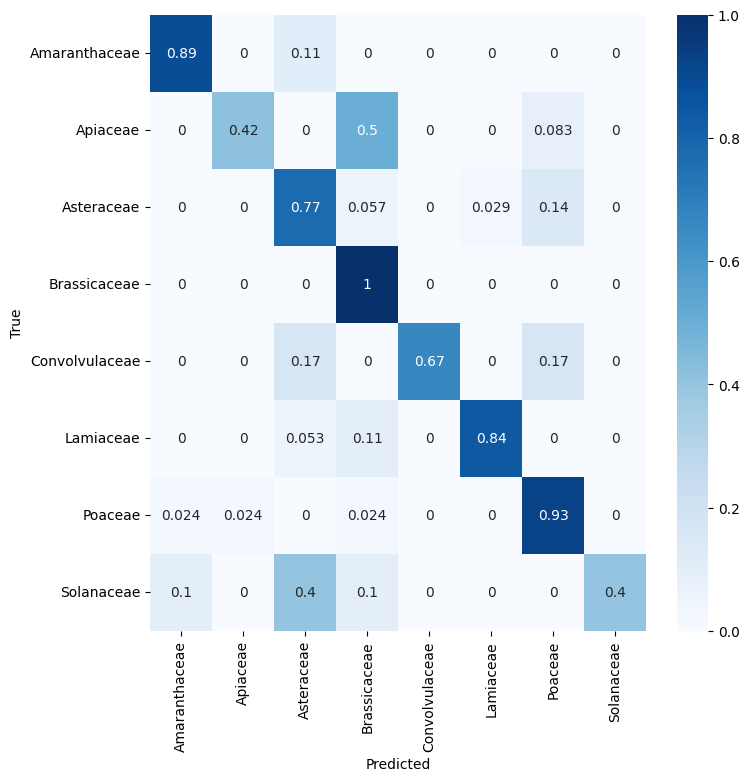

                precision    recall  f1-score   support

 Amaranthaceae       0.80      0.89      0.84         9
      Apiaceae       0.83      0.42      0.56        12
    Asteraceae       0.79      0.77      0.78        35
  Brassicaceae       0.48      1.00      0.65        11
Convolvulaceae       1.00      0.67      0.80         6
     Lamiaceae       0.94      0.84      0.89        19
       Poaceae       0.85      0.93      0.89        42
    Solanaceae       1.00      0.40      0.57        10

      accuracy                           0.79       144
     macro avg       0.84      0.74      0.75       144
  weighted avg       0.83      0.79      0.79       144



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=class_names))


## Modelos pré treinados


*  VGG19
*  ResNet152
*  ResNet50
*  ResNet101
*  MobileNetV3
*  MobileNetV2


In [ ]:
from tensorflow.keras.applications import VGG19, ResNet152, ResNet50, ResNet101, MobileNetV3Large, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.RandomContrast(0.1),
])

resize_layer = tf.keras.layers.Resizing(224, 224)

def preprocess_image(image, label):
    image = normalization_layer(image)
    image = resize_layer(image)
    image = data_augmentation(image)
    return image, label

def resize_image(image, label):
  image = normalization_layer(image)
  image = resize_layer(image)
  return image, label

augmented_train_ds = train_ds.map(preprocess_image)
resized_val_ds = val_ds.map(resize_image)
resized_test_ds = test_ds.map(resize_image)

In [ ]:
def fine_tune_model(base_model, loss='focal_loss', class_weights=None, train_ds=None, val_ds=None, epochs=30):
  for layer in base_model.layers:
    layer.trainable = False

  x = base_model.output
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu')(x)
  predictions = layers.Dense(num_classes)(x)

  model = Model(inputs=base_model.input, outputs=predictions)
  if loss == 'focal_loss':
    model.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy'])
  else:
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'], loss_weights=class_weights)

  history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

  return model, history


def evaluate_model(model, test_ds, class_names, ax):
  predictions = model.predict(test_ds)
  predicted_labels = np.argmax(predictions, axis=1)
  true_labels = np.concatenate([y for x, y in test_ds], axis=0)

  conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

  sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=ax)
  plt.xlabel('Predicted')
  plt.ylabel('True')

  report = classification_report(true_labels, predicted_labels, target_names=class_names)

  return report


def generate_fc_wce_comparison(fc_model, wce_model, test_ds, class_names):
  print("evaluating with test data")
  fig, axs = plt.subplots(1,2,figsize=(16, 8))

  report_fc = evaluate_model(fc_model, test_ds, class_names, axs[0])
  report_wce = evaluate_model(wce_model, test_ds, class_names, axs[1])

  axs[0].set_title('Confusion matrix - Focal loss')
  axs[1].set_title('Confusion matrix - Weighted cross entropy')

  return fig, report_fc, report_wce

def build_focal_weighted_loss_comparision(base_model, train_ds, val_ds, epochs):
  print("Training with focal loss")
  model_fc, history_fc = fine_tune_model(base_model, train_ds=train_ds, val_ds=val_ds, epochs=epochs) # focal loss

  print("Training with weighted cross entropy")
  model_wce, history_wce = fine_tune_model(base_model, train_ds=train_ds, loss='weighted', class_weights=class_weights, val_ds=val_ds, epochs=epochs) # weighted-cross-entropy

  return model_fc, history_fc, model_wce, history_wce

### VGG19

In [ ]:
vgg19_model = VGG19(weights='imagenet', include_top=False)

for layer in vgg19_model.layers:
  layer.trainable = False

x = vgg19_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(num_classes)(x)

model = Model(inputs=vgg19_model.input, outputs=predictions)

#### With focal loss

In [ ]:
model.compile(optimizer='adam', loss=FocalLoss(), metrics=['accuracy'])
model.fit(augmented_train_ds, validation_data=resized_val_ds, epochs=epochs)

Epoch 1/30
16/16 [==============================] - 11s 612ms/step - loss: 0.3251 - accuracy: 0.3574 - val_loss: 0.2197 - val_accuracy: 0.4896
Epoch 2/30
16/16 [==============================] - 10s 620ms/step - loss: 0.2172 - accuracy: 0.5684 - val_loss: 0.1533 - val_accuracy: 0.6562
Epoch 3/30
16/16 [==============================] - 10s 625ms/step - loss: 0.1719 - accuracy: 0.6172 - val_loss: 0.1220 - val_accuracy: 0.6979
Epoch 4/30
16/16 [==============================] - 10s 617ms/step - loss: 0.1433 - accuracy: 0.6875 - val_loss: 0.1053 - val_accuracy: 0.7396
Epoch 5/30
16/16 [==============================] - 10s 612ms/step - loss: 0.1259 - accuracy: 0.7148 - val_loss: 0.1011 - val_accuracy: 0.7604
Epoch 6/30
16/16 [==============================] - 10s 621ms/step - loss: 0.1169 - accuracy: 0.7227 - val_loss: 0.1068 - val_accuracy: 0.6875
Epoch 7/30
16/16 [==============================] - 10s 620ms/step - loss: 0.1189 - accuracy: 0.6953 - val_loss: 0.0714 - val_accuracy: 0.8333

In [ ]:
predictions = model.predict(resized_test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in resized_test_ds], axis=0)

5/5 [==============================] - 1s 46ms/step


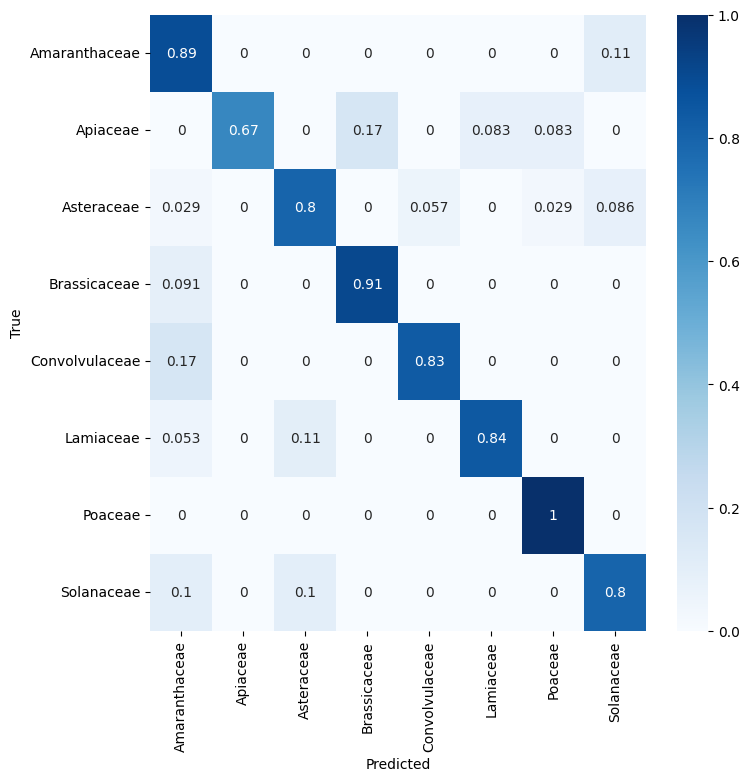

                precision    recall  f1-score   support

 Amaranthaceae       0.62      0.89      0.73         9
      Apiaceae       1.00      0.67      0.80        12
    Asteraceae       0.90      0.80      0.85        35
  Brassicaceae       0.83      0.91      0.87        11
Convolvulaceae       0.71      0.83      0.77         6
     Lamiaceae       0.94      0.84      0.89        19
       Poaceae       0.95      1.00      0.98        42
    Solanaceae       0.67      0.80      0.73        10

      accuracy                           0.87       144
     macro avg       0.83      0.84      0.83       144
  weighted avg       0.88      0.87      0.87       144



In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))

#### With weighted cross entropy

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'],
  loss_weights=class_weights
)

model.fit(augmented_train_ds, validation_data=resized_val_ds, epochs=epochs)

Epoch 1/30
16/16 [==============================] - 11s 638ms/step - loss: 0.3987 - accuracy: 0.9160 - val_loss: 0.3454 - val_accuracy: 0.9375
Epoch 2/30
16/16 [==============================] - 10s 635ms/step - loss: 0.3679 - accuracy: 0.9219 - val_loss: 0.4574 - val_accuracy: 0.8542
Epoch 3/30
16/16 [==============================] - 10s 635ms/step - loss: 0.3677 - accuracy: 0.9199 - val_loss: 0.5050 - val_accuracy: 0.8958
Epoch 4/30
16/16 [==============================] - 10s 620ms/step - loss: 0.3323 - accuracy: 0.9355 - val_loss: 0.4762 - val_accuracy: 0.8750
Epoch 5/30
16/16 [==============================] - 10s 626ms/step - loss: 0.3218 - accuracy: 0.9316 - val_loss: 0.4307 - val_accuracy: 0.8854
Epoch 6/30
16/16 [==============================] - 10s 631ms/step - loss: 0.2975 - accuracy: 0.9414 - val_loss: 0.3855 - val_accuracy: 0.8958
Epoch 7/30
16/16 [==============================] - 10s 629ms/step - loss: 0.3165 - accuracy: 0.9395 - val_loss: 0.4909 - val_accuracy: 0.8542

In [ ]:
predictions = model.predict(resized_test_ds)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in resized_test_ds], axis=0)

5/5 [==============================] - 1s 47ms/step


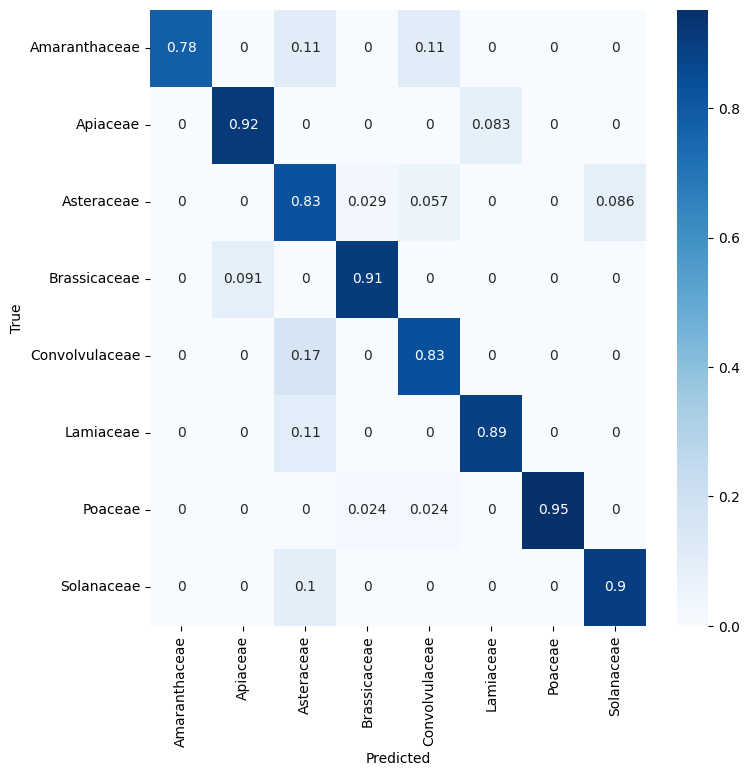

                precision    recall  f1-score   support

 Amaranthaceae       1.00      0.78      0.88         9
      Apiaceae       0.92      0.92      0.92        12
    Asteraceae       0.85      0.83      0.84        35
  Brassicaceae       0.83      0.91      0.87        11
Convolvulaceae       0.56      0.83      0.67         6
     Lamiaceae       0.94      0.89      0.92        19
       Poaceae       1.00      0.95      0.98        42
    Solanaceae       0.75      0.90      0.82        10

      accuracy                           0.89       144
     macro avg       0.86      0.88      0.86       144
  weighted avg       0.90      0.89      0.89       144



In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))


### ResNet152

Training with focal loss
Epoch 1/30
16/16 [==============================] - 36s 2s/step - loss: 0.4205 - accuracy: 0.5039 - val_loss: 0.1129 - val_accuracy: 0.8229
Epoch 2/30
16/16 [==============================] - 24s 2s/step - loss: 0.0816 - accuracy: 0.8320 - val_loss: 0.0399 - val_accuracy: 0.9688
Epoch 3/30
16/16 [==============================] - 24s 2s/step - loss: 0.0505 - accuracy: 0.8848 - val_loss: 0.0261 - val_accuracy: 0.9375
Epoch 4/30
16/16 [==============================] - 24s 2s/step - loss: 0.0303 - accuracy: 0.9355 - val_loss: 0.0269 - val_accuracy: 0.9167
Epoch 5/30
16/16 [==============================] - 24s 2s/step - loss: 0.0219 - accuracy: 0.9551 - val_loss: 0.0182 - val_accuracy: 0.9583
Epoch 6/30
16/16 [==============================] - 24s 2s/step - loss: 0.0239 - accuracy: 0.9414 - val_loss: 0.0140 - val_accuracy: 0.9479
Epoch 7/30
16/16 [==============================] - 24s 2s/step - loss: 0.0180 - accuracy: 0.9473 - val_loss: 0.0180 - val_accuracy: 0.

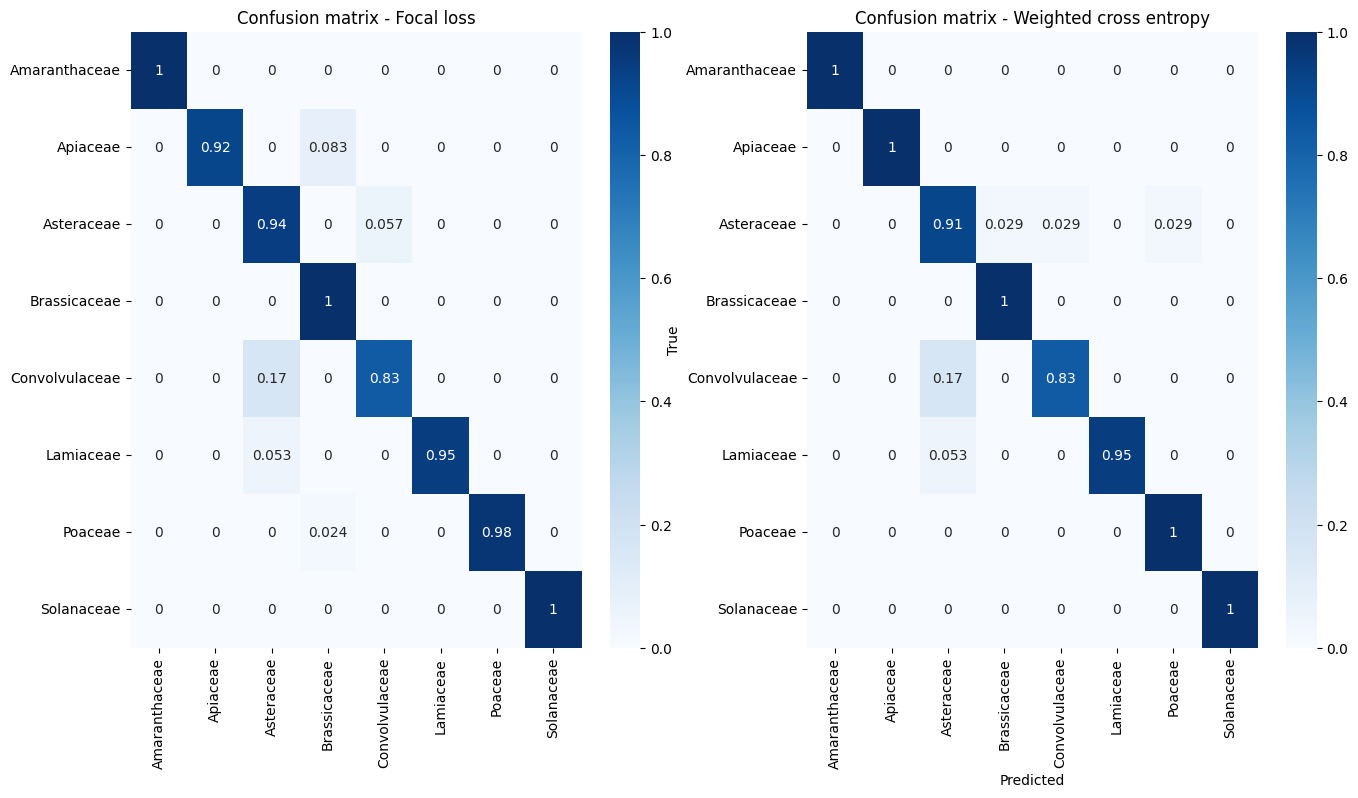

In [ ]:
resnet152_model = ResNet152(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet152_model_fc, resnet152_history_fc, resnet152_model_wce, resnet152_history_wce = build_focal_weighted_loss_comparision(resnet152_model, train_ds, val_ds, epochs=epochs)

fig_resnet152, resnet152_fc_report, resnet152_wce_report = generate_fc_wce_comparison(resnet152_model_fc, resnet152_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet152_fc_report)

print("General results for WCE")
print(resnet152_wce_report)

### ResNet50

Training with focal loss
Epoch 1/30
16/16 [==============================] - 16s 797ms/step - loss: 0.5709 - accuracy: 0.3984 - val_loss: 0.1261 - val_accuracy: 0.7500
Epoch 2/30
16/16 [==============================] - 11s 725ms/step - loss: 0.1199 - accuracy: 0.7676 - val_loss: 0.0718 - val_accuracy: 0.8333
Epoch 3/30
16/16 [==============================] - 11s 725ms/step - loss: 0.0611 - accuracy: 0.8555 - val_loss: 0.0317 - val_accuracy: 0.9167
Epoch 4/30
16/16 [==============================] - 11s 726ms/step - loss: 0.0362 - accuracy: 0.9199 - val_loss: 0.0392 - val_accuracy: 0.8750
Epoch 5/30
16/16 [==============================] - 12s 727ms/step - loss: 0.0311 - accuracy: 0.9355 - val_loss: 0.0313 - val_accuracy: 0.9167
Epoch 6/30
16/16 [==============================] - 12s 727ms/step - loss: 0.0243 - accuracy: 0.9492 - val_loss: 0.0302 - val_accuracy: 0.9062
Epoch 7/30
16/16 [==============================] - 11s 726ms/step - loss: 0.0225 - accuracy: 0.9434 - val_loss: 0.03

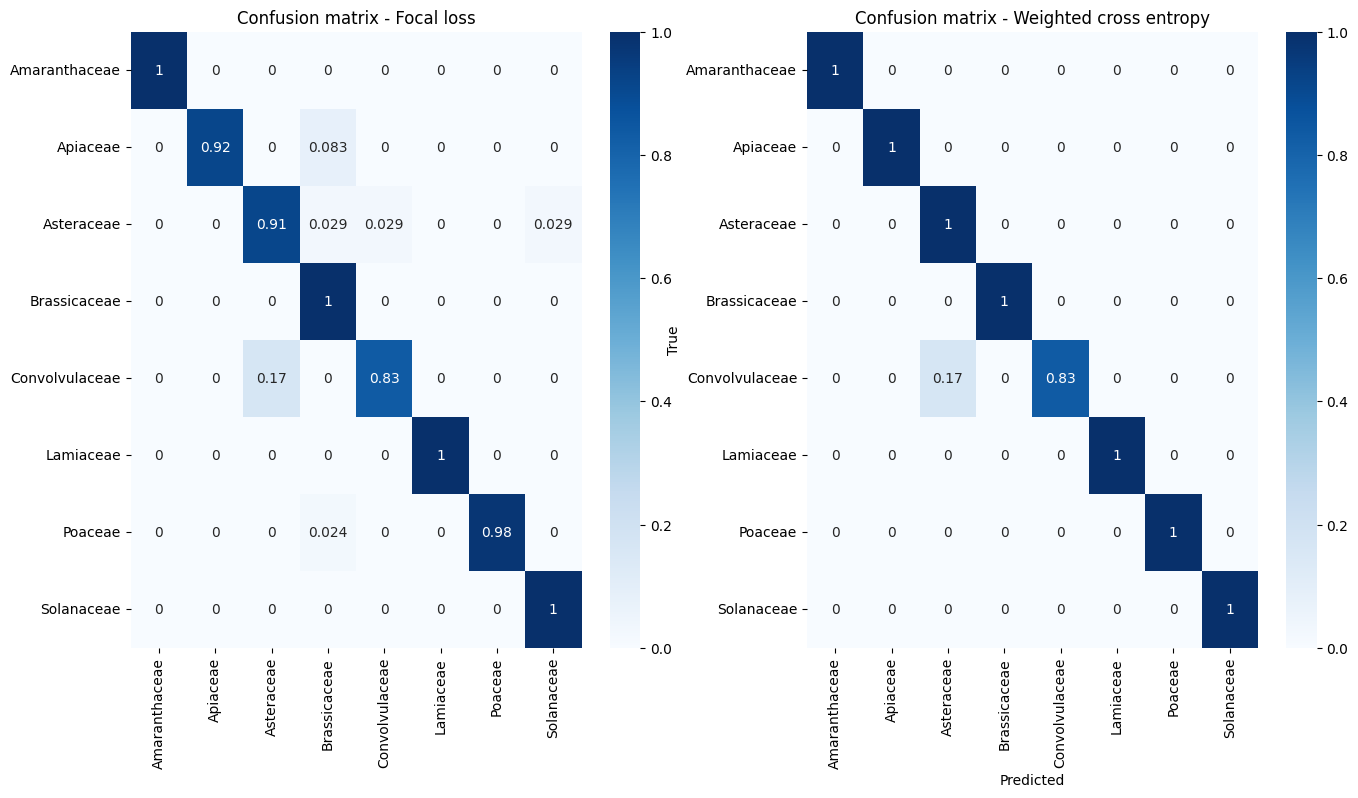

In [ ]:
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet50_model_fc, resnet50_history_fc, resnet50_model_wce, resnet50_history_wce = build_focal_weighted_loss_comparision(resnet50_model, train_ds, val_ds, epochs=epochs)

fig_resnet50, resnet50_fc_report, resnet50_wce_report = generate_fc_wce_comparison(resnet50_model_fc, resnet50_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet50_fc_report)

print("General results for WCE")
print(resnet50_wce_report)

### ResNet 101

16/16 [==============================] - 49s 3s/step - loss: 0.0284 - accuracy: 0.9277 - val_loss: 0.0270 - val_accuracy: 0.8854
Epoch 6/30
12/16 [=====================>........] - ETA: 4s - loss: 0.0221 - accuracy: 0.9479Training with focal loss
Epoch 1/30
16/16 [==============================] - 25s 1s/step - loss: 0.4768 - accuracy: 0.4570 - val_loss: 0.2204 - val_accuracy: 0.6146
Epoch 2/30
16/16 [==============================] - 18s 1s/step - loss: 0.1080 - accuracy: 0.7773 - val_loss: 0.0856 - val_accuracy: 0.7292
Epoch 3/30
16/16 [==============================] - 18s 1s/step - loss: 0.0574 - accuracy: 0.8418 - val_loss: 0.0645 - val_accuracy: 0.8229
Epoch 4/30
16/16 [==============================] - 18s 1s/step - loss: 0.0361 - accuracy: 0.9062 - val_loss: 0.0169 - val_accuracy: 0.9792
Epoch 5/30
16/16 [==============================] - 17s 1s/step - loss: 0.0241 - accuracy: 0.9512 - val_loss: 0.0150 - val_accuracy: 0.9688
Epoch 6/30
16/16 [==============================] - 1

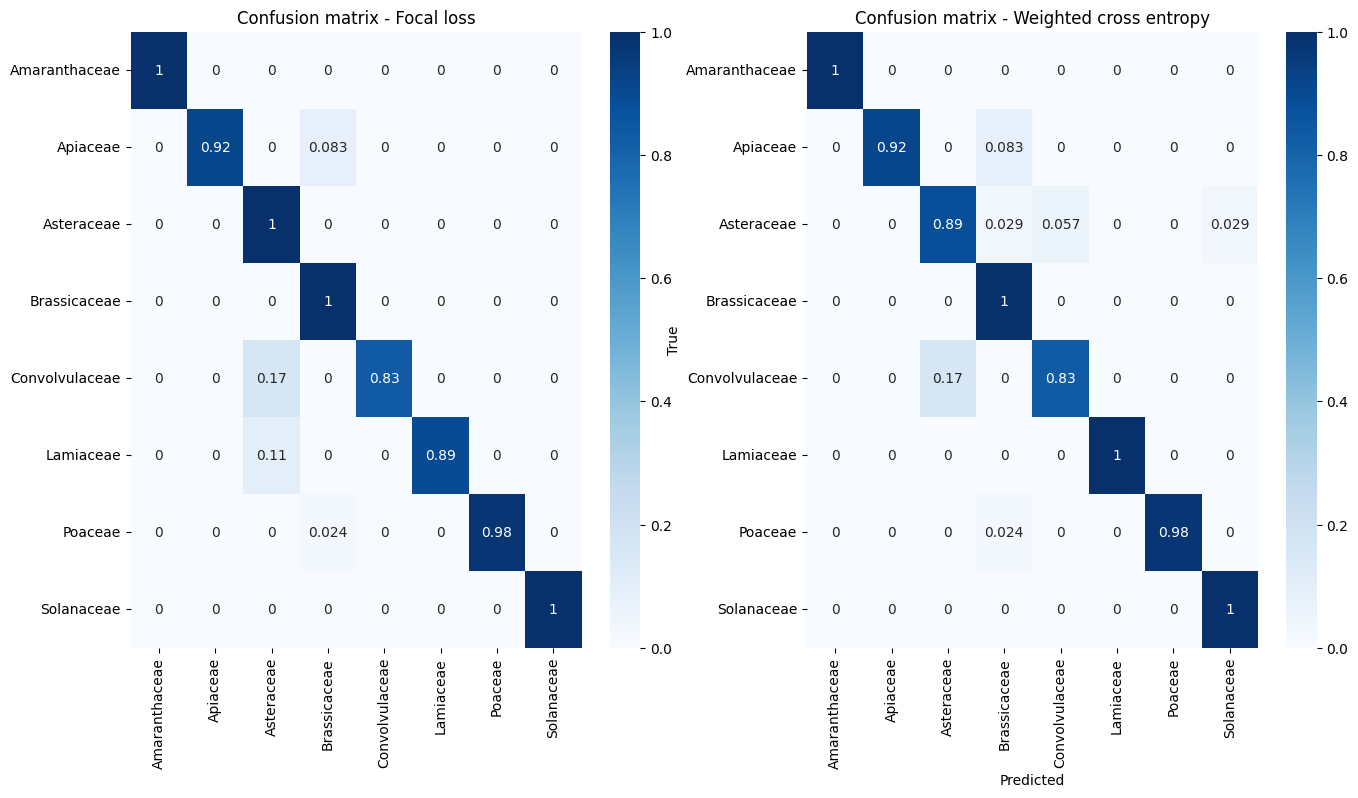

In [ ]:
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
resnet101_model_fc, resnet101_history_fc, resnet101_model_wce, resnet101_history_wce = build_focal_weighted_loss_comparision(resnet101_model, train_ds, val_ds, epochs=epochs)

fig_resnet101, resnet101_fc_report, resnet101_wce_report = generate_fc_wce_comparison(resnet101_model_fc, resnet101_model_wce, test_ds, class_names)
print("General results for focal loss")
print(resnet101_fc_report)

print("General results for WCE")
print(resnet101_wce_report)

### MobileNetV3

evaluating with test data
5/5 [==============================] - 2s 294ms/step
General results for focal loss
                precision    recall  f1-score   support

 Amaranthaceae       0.90      1.00      0.95         9
      Apiaceae       1.00      0.92      0.96        12
    Asteraceae       1.00      1.00      1.00        35
  Brassicaceae       0.85      1.00      0.92        11
Convolvulaceae       1.00      0.83      0.91         6
     Lamiaceae       1.00      1.00      1.00        19
       Poaceae       1.00      0.95      0.98        42
    Solanaceae       0.91      1.00      0.95        10

      accuracy                           0.97       144
     macro avg       0.96      0.96      0.96       144
  weighted avg       0.98      0.97      0.97       144

General results for WCE
                precision    recall  f1-score   support

 Amaranthaceae       0.90      1.00      0.95         9
      Apiaceae       1.00      0.92      0.96        12
    Asteraceae       1

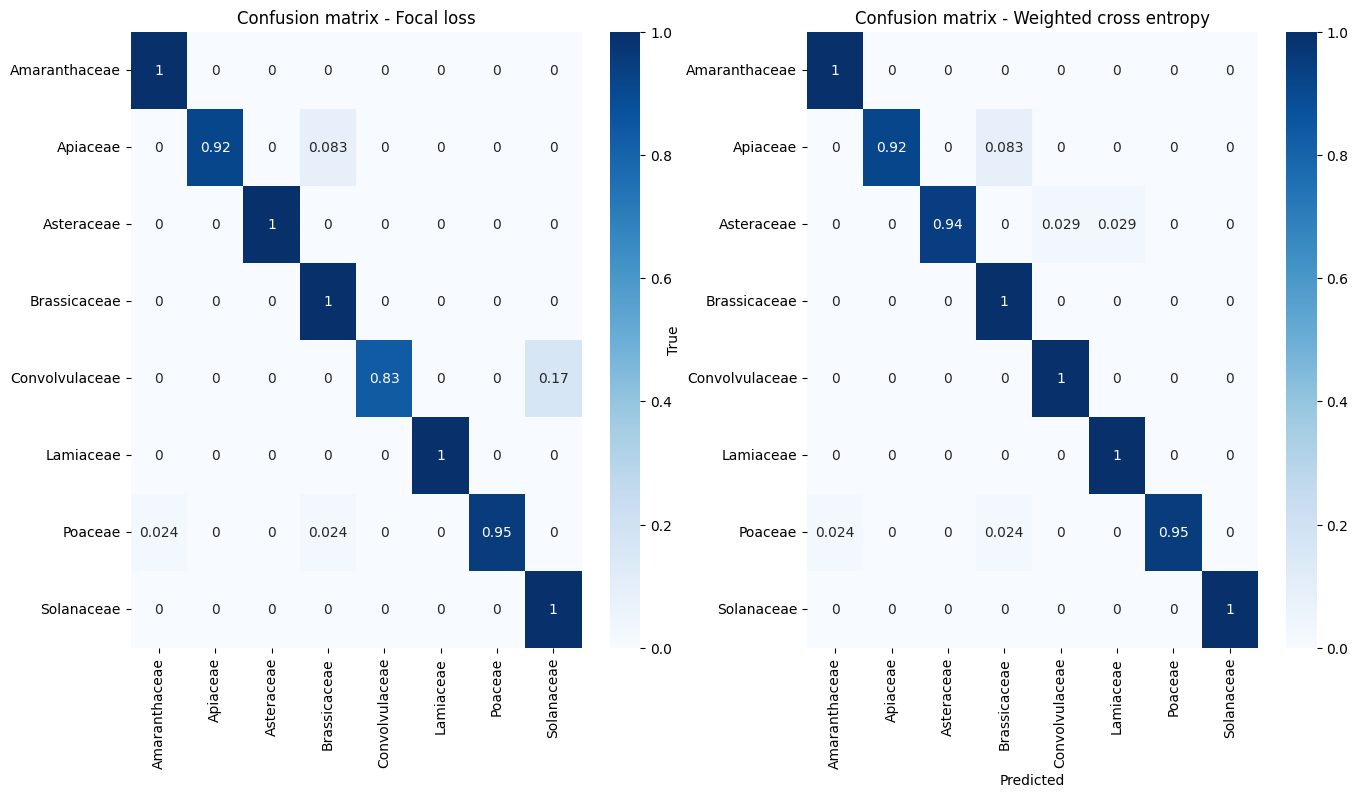

In [ ]:
mobile_net_V3_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
mobile_net_V3_model_fc, mobile_net_V3_history_fc, mobile_net_V3_model_wce, mobile_net_V3_history_wce = build_focal_weighted_loss_comparision(mobile_net_V3_model, train_ds, val_ds, epochs=epochs)

fig_mobile_net_V3, mobile_net_V3_fc_report, mobile_net_V3_wce_report = generate_fc_wce_comparison(mobile_net_V3_model_fc, mobile_net_V3_model_wce, test_ds, class_names)
print("General results for focal loss")
print(mobile_net_V3_fc_report)

print("General results for WCE")
print(mobile_net_V3_wce_report)

### MobileNetV2

9406464/9406464 [==============================] - 1s 0us/step
Training with focal loss
Epoch 1/30
16/16 [==============================] - 12s 502ms/step - loss: 0.3988 - accuracy: 0.3184 - val_loss: 0.2375 - val_accuracy: 0.4896
Epoch 2/30
16/16 [==============================] - 7s 421ms/step - loss: 0.2571 - accuracy: 0.4785 - val_loss: 0.2405 - val_accuracy: 0.4583
Epoch 3/30
16/16 [==============================] - 7s 417ms/step - loss: 0.2104 - accuracy: 0.5605 - val_loss: 0.1847 - val_accuracy: 0.5833
Epoch 4/30
16/16 [==============================] - 7s 419ms/step - loss: 0.1834 - accuracy: 0.6191 - val_loss: 0.1542 - val_accuracy: 0.6771
Epoch 5/30
16/16 [==============================] - 7s 417ms/step - loss: 0.1574 - accuracy: 0.6719 - val_loss: 0.1525 - val_accuracy: 0.7083
Epoch 6/30
16/16 [==============================] - 7s 437ms/step - loss: 0.1452 - accuracy: 0.6914 - val_loss: 0.1184 - val_accuracy: 0.7292
Epoch 7/30
16/16 [==============================] - 7s 421m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


General results for focal loss
                precision    recall  f1-score   support

 Amaranthaceae       0.82      1.00      0.90         9
      Apiaceae       1.00      0.83      0.91        12
    Asteraceae       0.83      0.86      0.85        35
  Brassicaceae       0.85      1.00      0.92        11
Convolvulaceae       1.00      0.83      0.91         6
     Lamiaceae       1.00      0.84      0.91        19
       Poaceae       0.98      1.00      0.99        42
    Solanaceae       0.80      0.80      0.80        10

      accuracy                           0.91       144
     macro avg       0.91      0.90      0.90       144
  weighted avg       0.92      0.91      0.91       144

General results for WCE
                precision    recall  f1-score   support

 Amaranthaceae       1.00      0.67      0.80         9
      Apiaceae       1.00      0.67      0.80        12
    Asteraceae       0.70      0.86      0.77        35
  Brassicaceae       0.65      1.00      0.79

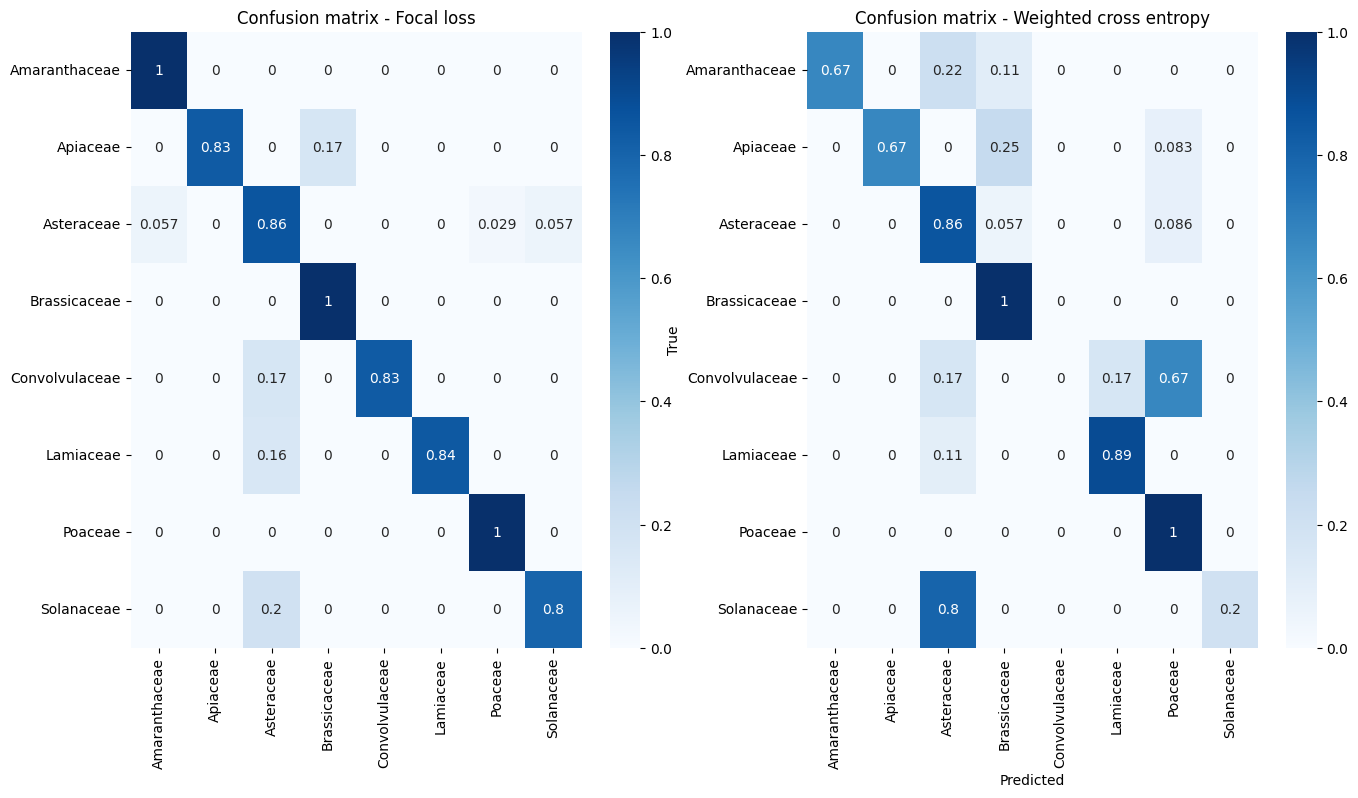

In [ ]:
mobile_net_V2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
mobile_net_V2_model_fc, mobile_net_V2_history_fc, mobile_net_V2_model_wce, mobile_net_V2_history_wce = build_focal_weighted_loss_comparision(mobile_net_V2_model, train_ds, val_ds, epochs=epochs)

fig_mobile_net_V2, mobile_net_V2_fc_report, mobile_net_V2_wce_report = generate_fc_wce_comparison(mobile_net_V2_model_fc, mobile_net_V2_model_wce, test_ds, class_names)
print("General results for focal loss")
print(mobile_net_V2_fc_report)

print("General results for WCE")
print(mobile_net_V2_wce_report)